In [2]:
# moved to model_dev from ./
# it might affect followig appends
import sys
sys.path.append('data')
sys.path.append('icons')
sys.path.append('dl_models')

In [3]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import time
import regression as worker
import nangs
import torch.nn.functional as F

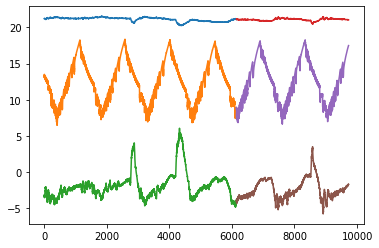

In [43]:
torch.manual_seed(1618)
file_name = 'vectors2.csv'
train_validation = 0.66
bsize = 512
device = 'cpu'#cuda' if torch.cuda.is_available() else 'cpu'
ts = pd.read_csv('data/model_input/' + file_name, sep=',')
tint = ts['tint'].values
text = ts['text'].values
q = ts['q'].values
tv_index_middle = int((train_validation * len(q)) / bsize) * bsize
tint_train = tint[0:tv_index_middle]
text_train = text[0:tv_index_middle]
q_train = q[0:tv_index_middle]
tv_index_last = int((len(q) - tv_index_middle) / bsize) * bsize + tv_index_middle
tint_validation = tint[tv_index_middle:tv_index_last]
text_validation = text[tv_index_middle:tv_index_last]
q_validation = q[tv_index_middle:tv_index_last]
index_train = [i for i in range(tv_index_middle)]
index_validation = [i for i in range(tv_index_middle, tv_index_last)]
plt.plot(index_train, tint_train)
plt.plot(index_train, text_train)
plt.plot(index_train, q_train)
plt.plot(index_validation, tint_validation)
plt.plot(index_validation, text_validation)
plt.plot(index_validation, q_validation)


In [80]:
input = torch.tensor(np.column_stack((tint_train, text_train))).view(bsize, 2, int(len(q_train)/bsize))
print(input.shape)
print(input[:,:,0].shape)
qtrue = torch.tensor(q_train).view(bsize, 1, int(len(q_train)/bsize))
qtrue.shape
input = input.to(device).float()
qtrue = qtrue.to(device).float()
qtrue.shape

torch.Size([512, 2, 12])
torch.Size([512, 2])


torch.Size([512, 1, 12])

In [98]:
class MLP(nn.Module):
    def __init__(self, device):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(2, 100).to(device).float()
        self.linear2 = nn.Linear(100, 100).to(device).float()
        self.linear3 = nn.Linear(100, 1).to(device).float()
        self.transform_q = nn.Linear(1, 1).to(device).float()
    
    def forward(self, input,):
        input = input.float()
        x = F.relu(self.linear1(input))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.transform_q(x)
        return x


In [99]:
model = MLP(device)
output = model(input[:,:,0])
output.shape

torch.Size([512, 1])

In [100]:
input_validation = torch.tensor(np.column_stack((tint_validation, text_validation))).view(bsize, 2, int(len(q_validation)/bsize))
qtrue_validation = torch.tensor(q_validation).view(bsize, 1, int(len(q_validation)/bsize))

In [101]:
loss_list = []
loss_val_list = []
nepochs = 5000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
init = (input[0, 0, 0] + input[0, 1, 0]) / 2 
loss_fn = torch.nn.MSELoss()

for epoch in range(nepochs):
    loss_epoch = []
    for batch in range(input.shape[2]):
        model.train()
        start_time = time.time()
        optimizer.zero_grad()
        qhat = model(input[:, :, batch])
        loss = loss_fn(qhat, qtrue[:, :, batch])
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())
    loss_list.append(loss_epoch[-1])

    with torch.no_grad():
        prediction_train = []
        for batch in range(input.shape[2]):
            model.eval()
            qhat = model(input[:, :, batch])
            qhat = torch.flatten(qhat).cpu().detach().numpy()
            prediction_train = np.append(prediction_train, qhat)
        
        prediction_validation = []
        for batch in range(input_validation.shape[2]):
            model.eval()
            qhat = model(input_validation[:, :, batch])
            qhat = torch.flatten(qhat).cpu().detach().numpy()
            prediction_validation = np.append(prediction_validation, qhat)
        
        loss_val = (np.square(prediction_validation - qtrue_validation.flatten().detach().numpy())).mean()
        loss_val_list.append(loss_val)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, train loss: {loss.item()}, validation loss: {loss_val.item()} execution per step: {time.time() - start_time}')


Epoch: 0, train loss: 9.421998977661133, validation loss: 10.991584318839484 execution per step: 0.02763676643371582
Epoch: 100, train loss: 8.842277526855469, validation loss: 10.290675052888007 execution per step: 0.009815216064453125
Epoch: 200, train loss: 8.29930591583252, validation loss: 9.628437558055307 execution per step: 0.007376194000244141
Epoch: 300, train loss: 7.788590431213379, validation loss: 8.999625997477251 execution per step: 0.007761716842651367
Epoch: 400, train loss: 7.307520389556885, validation loss: 8.401177369416438 execution per step: 0.008765459060668945
Epoch: 500, train loss: 6.854768753051758, validation loss: 7.831538676414776 execution per step: 0.011321783065795898
Epoch: 600, train loss: 6.429697513580322, validation loss: 7.28999134223345 execution per step: 0.0078105926513671875
Epoch: 700, train loss: 6.031994342803955, validation loss: 6.776208479025302 execution per step: 0.007920026779174805
Epoch: 800, train loss: 5.661470413208008, validat

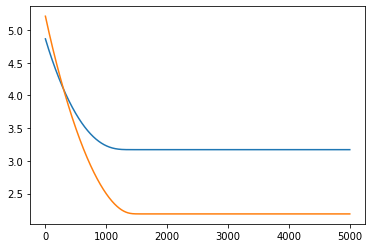

In [90]:
plt.plot(loss_list)
plt.plot(loss_val_list)

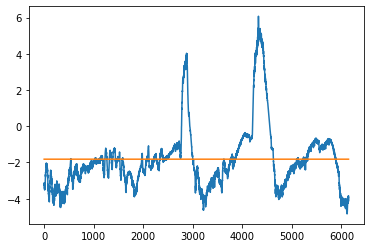

In [92]:
plt.plot(qtrue.flatten())
plt.plot(prediction_train)

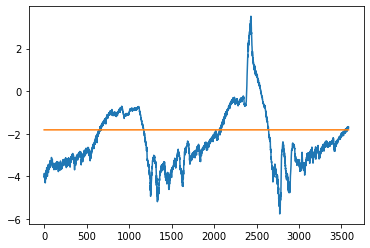

In [93]:
plt.plot(qtrue_validation.flatten())
plt.plot(prediction_validation)


In [45]:
model = torch.load('results/models/vectors_zg_LSTM_b64_nl32_pd2_opAdam.pt')


In [46]:
model

Dl_model(
  (linear): Linear(in_features=2048, out_features=64, bias=True)
  (lstm): LSTM(64, 64, num_layers=32)
  (dropout): Dropout(p=0.2, inplace=False)
)

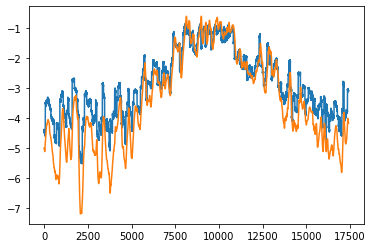

In [48]:
model.eval()
ts = pd.read_csv('data/model_input/vectors_zg.csv', sep=',')
data_worker = worker.Dset(ts, train_validation=1, avg_const=1)
v1_avg, v2_avg = data_worker.ts_average()
split_list = data_worker.tv_split(v1_avg, v2_avg, 64)
v1_train = torch.tensor(split_list[0])
v2_train = torch.tensor(split_list[1])
prediction_list = []
bdiv = int(len(v1_train) / 64)
v1_train = v1_train.view(bdiv, 1, 64)
v2_train = v2_train.view(bdiv, 1, 64)
for batch in range(bdiv):
    prediction = model.forward(v1_train[batch][0])
    prediction = torch.flatten(prediction).cpu().detach().numpy()
    prediction_list = np.append(prediction_list, prediction)

#u_list = []
#for i in range(len(v1_train.flatten())):
#    n = i + 1
#    deltat = v1_train.flatten().cpu().numpy()
#    q = v2_train.flatten().cpu().numpy()
#    deltat = np.sum(deltat[0:n]) / (n + 1)
#    q = np.sum(q[0:n]) / (n + 1)
#    u = q / deltat
#    u_list.append(u)

plt.plot(prediction_list)
plt.plot(v2_train.flatten())
